# Demo of the AutoML library

In [1]:
import sys
sys.path.append('..')

from automl import AutoML, ProblemClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import TransformerMixin

from scipy.stats import pearsonr

import pandas as pd
import numpy as np

%matplotlib inline

import sys, os
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

### Data

Will test `AutoML` on the classification problem. Dataset represents shots made by Kobe Bryant. Target is represents whether Kobe made a shot and features are info about the shot (like its type, position, etc.)

In [2]:
target = 'shot_made_flag'
df = pd.read_csv('data.csv')

In [3]:
df= df[~np.isnan(df[target])]
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


In [4]:
df, df_test = train_test_split(df, test_size=0.2)
X, y = df.drop(target, axis=1), df[target]

## Initial preprocessing pipeline

Initial (manual) preprocessing would just be removing of the `'shot_id'` and '`'game_date'` columns. Preprocessing pipeline has to implement `fit` and `transform` methods (e.g. `TransformerMixin` or `Pipeline` from `sklearn.pipeline`)

In [5]:
class DropIdAndDate(TransformerMixin):

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X, **kwargs):
        return X.drop(['shot_id', 'game_date'], axis=1)

    def __repr__(self):
        return 'Drop shot_id and game_date'

## Fitting

Will fit our training data. `AutoML` will automaticaly decide which of the models to use.

Won't have any time limit (`max_time = 0`) so this part takes 10-20 mins.

In [6]:
auto_ml = AutoML(
    max_time = 0,
    problem_type=ProblemClassifier.CLASSIFICATION, 
    initial_preprocessing_pipeline=DropIdAndDate()
)
model = auto_ml.fit(X, y)

## Generated pipeline

In [7]:
model.describe()

Initial pipeline:
	Drop shot_id and game_date
Preprocessing pipeline:
	Constant columns drop:
		Constant columns: ['team_id', 'team_name']
	Scaler:
		MinMaxScaler(copy=True, feature_range=(0, 1))
	Categorical converter:
		Ordinal: [], Nominal: ['shot_zone_basic', 'season', 'matchup', 'shot_zone_area', 'shot_type', 'opponent', 'action_type', 'shot_zone_range', 'combined_shot_type']
Model:
	LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


## Accuracy

In [8]:
predictions = model.predict(df_test.drop(target, axis=1))
(df_test[target] == predictions).mean()

0.685408560311284

## Evaluation of metamodels prediction

In [9]:
actual_order = sorted(auto_ml.model_evaluator.relative_landmarks, key=lambda m: m[1], reverse=True)

In [10]:
auto_ml.model_evaluator._meta_models = auto_ml.model_evaluator._get_meta_models()
auto_ml.model_evaluator.time_limit = 1
predicted_order = auto_ml.model_evaluator._models_in_predicted_order(auto_ml.meta_extractor.as_dict())

In [11]:
actual_order = list(map(lambda x: x[0][0].__name__, actual_order))
predicted_order = list(map(lambda x: x[0].__name__, predicted_order))

In [12]:
pd.DataFrame({'actual': actual_order, 'predicted': predicted_order})

,actual,predicted
0,LogisticRegression,GaussianNB
1,LinearSVC,NearestCentroid
2,MultinomialNB,ExtraTreeClassifier
3,CalibratedClassifierCV,MultinomialNB
4,AdaBoostClassifier,CalibratedClassifierCV
5,BernoulliNB,DecisionTreeClassifier
6,NearestCentroid,AdaBoostClassifier
7,GradientBoostingClassifier,PassiveAggressiveClassifier
8,RandomForestClassifier,LinearSVC
9,ExtraTreesClassifier,MLPClassifier


This plot shows models in the order of their actual accuracies (x axis) and their position in the order of predicted accuracies (y axis). So we would expect increasing line from the perfect metamodels.

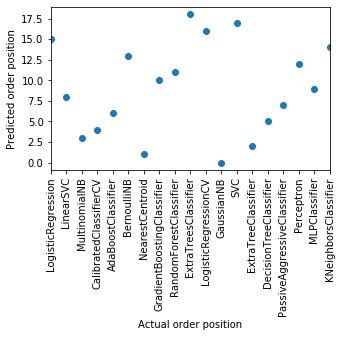

In [13]:
pred_df = pd.DataFrame(list(map(lambda x: predicted_order.index(x), actual_order)))
ax = pred_df.plot(style='o', figsize=(5, 3), legend=False)
ax.set_xticklabels(actual_order, rotation='vertical')
ax.set_ylabel('Predicted order position')
ax.set_xlabel('Actual order position')
_ = ax.set_xticks(pred_df.index)

The correlation is positive (as expected) but insignificant.

In [14]:
corr, p = pearsonr(pred_df.index, pred_df[0])
corr

0.11228070175438595